In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TRAIN_SPLIT = 11000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 50

In [2]:
# data frame
csv_path = os.path.abspath('../server/src/csv/gb.csv')
df = pd.read_csv(csv_path, header=1)
df = df.rename(columns={"Unnamed: 0":"date", "last_price":"close"})
df

,date,high,low,open,close
0,04/01/1971,2.3938,2.3938,2.3938,2.3938
1,05/01/1971,2.3949,2.3949,2.3949,2.3949
2,06/01/1971,2.3967,2.3967,2.3967,2.3967
3,07/01/1971,2.3963,2.3963,2.3963,2.3963
4,08/01/1971,2.3972,2.3972,2.3972,2.3972
...,...,...,...,...,...
12805,03/02/2020,1.3215,1.2983,1.3215,1.2995
12806,04/02/2020,1.3047,1.2941,1.2995,1.3031
12807,05/02/2020,1.3070,1.2956,1.3031,1.3002
12808,06/02/2020,1.3003,1.2921,1.3002,1.2931


In [3]:
features_considered = ['high', 'low', 'open', 'close']
features = df[features_considered]
features.index = df['date']
features.head()

,high,low,open,close
date,,,,
04/01/1971,2.3938,2.3938,2.3938,2.3938
05/01/1971,2.3949,2.3949,2.3949,2.3949
06/01/1971,2.3967,2.3967,2.3967,2.3967
07/01/1971,2.3963,2.3963,2.3963,2.3963
08/01/1971,2.3972,2.3972,2.3972,2.3972


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a2dd72490>,
      dtype=object)

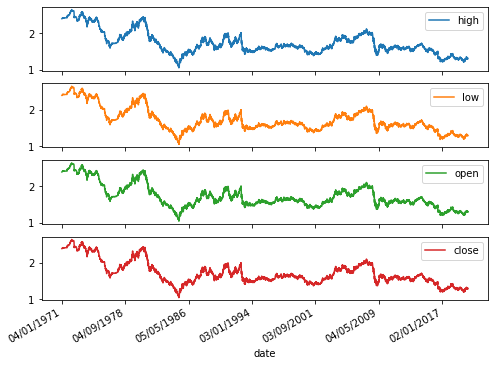

In [4]:
features.plot(subplots=True)

In [5]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
dataset

array([[ 1.97531264,  1.98428734,  1.97987199,  1.97973999],
       [ 1.97883383,  1.98777758,  1.9833784 ,  1.98324631],
       [ 1.98459578,  1.9934889 ,  1.98911616,  1.98898393],
       ...,
       [-1.50362398, -1.50024885, -1.49689323, -1.50618052],
       [-1.52507123, -1.51135418, -1.50613741, -1.52881222],
       [-1.53915599, -1.5237287 , -1.52876969, -1.54124373]])

In [6]:
# single step model
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [8]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 4)


In [9]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [10]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [11]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 4s 19ms/step - loss: 0.0959 - val_loss: 0.2793
Epoch 2/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0976 - val_loss: 0.2754
Epoch 3/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0888 - val_loss: 0.2932
Epoch 4/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0863 - val_loss: 0.3054
Epoch 5/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0944 - val_loss: 0.3057
Epoch 6/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0818 - val_loss: 0.2856
Epoch 7/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0793 - val_loss: 0.3041
Epoch 8/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0764 - val_loss: 0.2797
Epoch 9/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0755 - val_loss: 0.2858
Epoch 10/50
200/200 [===========================

In [14]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

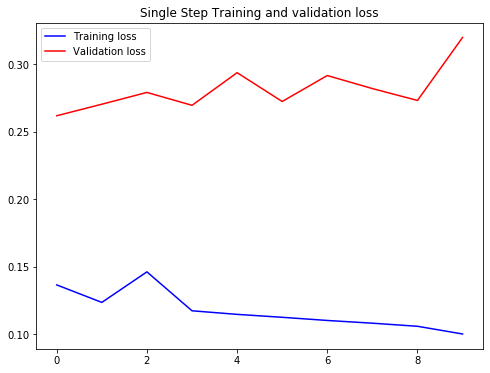

In [15]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')